In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import function_library_assignment_1 as fnc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #filtering FutureWarnings - we don't need to worry about them in this case
#(This is run using Python 3.9)

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

# Read data
gen_data = fnc.read_data('gen_data')
demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_costs = fnc.read_data('gen_costs')
line_data = fnc.read_data('line_data')
branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data')
all_bid_prices = fnc.read_data('all_bid_prices')

GC = len(gen_data.index)
GW = len(wind_data.columns)
G = GC + GW
D = len(load_distribution.index)
N = 24 # number of buses

WF_NODES = [2, 4, 6, 15, 20, 22] # zero-indexed
BESS_NODES = [2, 4, 6, 15, 20, 22] #note the nodes here are 0-indexed
B = len(BESS_NODES) # number of batteries

T = 24 # number of hours

S_BASE_MVA = 100 # base power of the network for per-unit calculations

# Define input parameters of batteries (per-unitized values for nodal power flow)
SOC_max = 1 # Maximum SOC capacity of each battery (per unit)
SOC_ini = 0 # initial SOC - will also be enforced at the end of the period
P_max_BESS = SOC_max # Maximum charging/discharging power of each battery (per unit)
eta_bess = 0.95 # charging and discharging efficiency

#This dictionary return the 0-indexed indices of generators or wind farms located at the node n

#for example, gens_map.get(0) will return the list [0] because generator 1 is placed at node 1
#gens_map.get(14) will return [4, 5] because generators 5 and 6 are at node 15

#if no generation units are located at node n, it will return an empty list

wf_df = pd.DataFrame(index=np.arange(12,18))
wf_df[['Unit #', 'Node']] = 0
wf_df['Type'] = 'WF'

for i in range(GC, G):
    wf_df.loc[i, 'Unit #'] = i + 1
    wf_df.loc[i, 'Node'] = WF_NODES[i-GC] + 1 #WF_NODES is 0-indexed, but the nodes are 1-indexed in the data

gen_nodes = gen_data[['Unit #', 'Node']].copy(deep=True)
gen_nodes['Type'] = 'CONVENTIONAL'
gen_nodes = pd.concat([gen_nodes, wf_df], ignore_index=True, axis=0)

gens_map = {}

for n in range(1, N + 1):
    gens_map[n - 1] = (gen_nodes['Unit #'][gen_nodes['Node'] == n] - 1).tolist()

bess_map = {}

for n in range(N):
    bess_map[n] = np.where(np.array(BESS_NODES) == n)[0].tolist()

load_map = {}

for n in range(1, N + 1):
    load_map[n - 1] = (load_distribution['Load #'][load_distribution['Node'] == n] - 1).tolist()

# Define the hourly load distribution
    
hourly_loads = {} #dictionary containing the hourly load distributions

for t in range(T):
    load = np.zeros(N)
    system_demand = demand[t]  # Update demand for each hour

    #Saving the load for each bus in a numpy array accounting for the system load destribution
    for n in load_distribution['Node'].unique():
        load[n-1] = load_distribution.loc[load_distribution['Node'] == n, r'% of system load'] / 100 * system_demand #load - remember that the data is not 0-indexed while the arrays are

    hourly_loads[t] = load #Save load for each hour


#Note that the hourly bid prices are randomized within a specified range for each hour, so the pattern is mostly random
for t in range(T):
    bid_prices = np.zeros(D)

    for n in range(D):
        bid_prices[n] = all_bid_prices.loc[all_bid_prices['Load #'] == (n + 1), f't{18}'] #use the bid prices for the same hour that we used for task 1

For sensitivity analysis in task 4: Reduce line capacity for line (15,21)...

In [61]:
#line_data.loc[(line_data.From == 15) & (line_data.To == 21), 'Capacity MVA'] = 300 # from 400 to 300
#line_data.loc[(line_data.From == 15) & (line_data.To == 21), 'Capacity pu'] = 3.0 

# Nodal model

In [62]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

#============= Variables =============
#NOTE: We now use per unitized values for power flows
theta = m.addVars(N, T, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="theta") #bus voltage angles
p_G = m.addVars(G, T, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: wind farms can be curtailed AND P_min from the system should be disregarded to avoid having a mixed integer program
p_D = m.addVars(D, T, lb=0, ub=gb.GRB.INFINITY, name="P_D") #Note: demands are elastic
p_B = m.addVars(B, T, lb = -gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="P_B") #battery power (charging is positive, discharging is negative)
bess_SOC = m.addVars(B, T, lb=0, ub=SOC_max, name="BESS_SOC") #battery state of charge

#============= Objective function =============
# Set objective function (social welfare) - note that production cost of wind farms is assumed to be zero
#remember transformation back to MW from per unit values
obj = gb.quicksum(bid_prices[d] * p_D[d,t] * S_BASE_MVA for d in range(D) for t in range(T)) - gb.quicksum(gen_costs['C ($/MWh)'][k] * p_G[k,t] * S_BASE_MVA for k in range(GC) for t in range(T))
m.setObjective(obj, direction)

#Note: Each constraint will appear for each hour t

#============= Balance equation =============
#Here, we've put the "addConstrs" iterative call inside a for-loop to group the 24 nodal constraints by hours
for t in range(T):
    m.addConstrs(gb.quicksum(p_D[d,t] for d in load_map.get(n)) 
                    - gb.quicksum(p_G[g,t] for g in gens_map.get(n)) 
                    + gb.quicksum(p_B[b,t] for b in bess_map.get(n)) 
                    + gb.quicksum(branch_matrix[n,k] * (theta[n,t] - theta[k,t]) for k in range(N) if k != n) 
                    == 0 for n in range(N))

m.addConstrs(theta[0,t] == 0 for t in range(T)) #reference bus angle is 0

#============= Transmission line flow constraints =============

#Remembering that the "to" and "from" are not zero-indexed in the line data
for n in range(N):
    for k in range(n, N): #Avoid duplicates by starting the indexing of k at i
            if (n != k) and (branch_matrix[n,k] != 0):
                m.addConstrs(branch_matrix[n,k] * (theta[n,t] - theta[k,t]) <= (line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum()) for t in range(T))
                m.addConstrs(branch_matrix[n,k] * (theta[n,t] - theta[k,t]) >= -1 * (line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum()) for t in range(T))

#============= Generator limits and ramping constraints ============
m.addConstrs(p_G[g,t] <= (gen_data['P max MW'].iloc[g]) / S_BASE_MVA for g in range(GC) for t in range(T)) #conventinal generator upper limits

#Maximum wind power is the per-unitized output of the non-curtailed wind farm in the hour t
m.addConstrs(p_G[GC + g, t] <= wind_data.iloc[t, g] / S_BASE_MVA for g in range(GW) for t in range(T)) #wind farm generator upper limits

#Ramping constraints
m.addConstrs(p_G[g,t] - p_G[g,t-1] <= (gen_data['RU MW/h'].iloc[g]) / S_BASE_MVA for g in range(GC) for t in range(1, T)) #ramping up limitation
m.addConstrs(p_G[g,t-1] - p_G[g,t] <= (gen_data['RD MW/h'].iloc[g]) / S_BASE_MVA for g in range(GC) for t in range(1, T)) #ramping down limitation

#============= Demand limits ===============
for t in range(T):
    load = hourly_loads[t].copy()
    m.addConstrs(p_D[d,t] <= load[load != 0][d] / S_BASE_MVA for d in range(D)) #demand limits

#============= Battery limits & state of charge ==============
m.addConstrs(p_B[b,t] <= P_max_BESS for b in range(B) for t in range(T))
m.addConstrs(p_B[b,t] >= -P_max_BESS for b in range(B) for t in range(T))

# Initial state of charge for BESSs
m.addConstrs(bess_SOC[b, 0] == SOC_ini for b in range(B)) #note that SOC is handled as SOC at the START of the hour

# Final SOC equal to initial SOC
m.addConstrs(bess_SOC[b, (T - 1)] + eta_bess * p_B[b,(T - 1)] == SOC_ini for b in range(B))

#Inter-temporal SOC balance
m.addConstrs(bess_SOC[b,t] == bess_SOC[b, (t-1)] + eta_bess * p_B[b,(t-1)] for b in range(B) for t in range(1, T)) 

#============= Display and run model =============
#m.update()
#m.display()
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 4062 rows, 1704 columns and 9144 nonzeros
Model fingerprint: 0x5bae2f47
Coefficient statistics:
  Matrix range     [9e-01, 2e+02]
  Objective range  [5e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 2641 rows and 210 columns
Presolve time: 0.02s
Presolved: 1421 rows, 2375 columns, 6063 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1192    7.6550229e+05   0.000000e+00   0.000000e+00      0s

Solved in 1192 iterations and 0.05 seconds (0.02 work units)
Optimal objective  7.655022852e+05


## Analyze results

In [63]:
print_variables = False

#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {}
    constraints = m.getConstrs()
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 

    overview = pd.DataFrame(data=np.zeros(T), columns=['Hour'], dtype=int)
    overview['Maximum Demand [MWh]'] = demand.values
    overview['Load [MWh]'] = 0
    overview['Total Production [MWh]'] = 0
    overview['Wind [MWh]'] = 0
    overview['Dispatchable Production [MWh]'] = 0
    overview['BESS Charging [MWh]'] = 0
    overview['BESS Discharging [MWh]'] = 0
    overview['AVERAGE Lambda [$/MWh]'] = 0

    overview[(r'Aggregated BESS SOC [%]')] = 0.0

    #Get results for each hour
    for t in range(T):
        print('==========================================================')
        print('HOUR %d\n' % t)

        hour_results = {}

        generator_outputs = pd.DataFrame(data=np.zeros(G), columns=['p_G'])
        generator_outputs['Node'] = 0 #initialize
        generator_outputs['Dispatched Percentage'] = 0
        generator_outputs['Type'] = 'Conventional'

        load = hourly_loads[t].copy()
        load_results = pd.DataFrame(data=np.zeros(D), columns=['p_D'])
        load_results['Node'] = load_distribution['Node'].values
        load_results['Maximum Demand'] = load[load != 0]

        bess_results = pd.DataFrame(data=np.zeros(B), columns=['Charging [pu]'])
        bess_results[['Discharging [pu]', 'SOC']] = 0.0
        bess_results['Node'] = 0 #initialize
        

        theta_dict = {}

        for i in range(G):
            if print_variables: print(p_G[i,t].VarName + ": %.2f MW" % (p_G[i,t].x * S_BASE_MVA))
            generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i,t].x

            if i < GC:
                generator_outputs.loc[generator_outputs.index == i, 'Node'] = gen_data.loc[gen_data.index == i, 'Node'].values #save node
                gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
                generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i,t].x * S_BASE_MVA / gen_limit) * 100
            else:
                generator_outputs.loc[generator_outputs.index == i, 'Node'] = WF_NODES[i - GC] + 1 #save node (from zero-indexed to 1-indexed)
                wind_limit = wind_data.iloc[t, i - GC]
                generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i,t].x * S_BASE_MVA / wind_limit) * 100
                generator_outputs.loc[generator_outputs.index == i, 'Type'] = 'Wind'

        for i in range(D):
            if print_variables: print(p_D[i,t].VarName + ": %.2f MW" % (p_D[i,t].x * S_BASE_MVA))
            load_results.loc[load_results.index == i, 'p_D'] = p_D[i,t].x

        for b in range(B):
            if print_variables: print(p_B[b,t].VarName + ": %.2f MW" % (p_B[b,t].x * S_BASE_MVA))
            if print_variables: print(bess_SOC[b,t].VarName + ": %.2f MWh" % (bess_SOC[b,t].x * S_BASE_MVA))
            bess_results.loc[bess_results.index == b, 'Node'] = BESS_NODES[b] + 1 #save node (from zero-indexed to 1-indexed)
            bess_results.loc[bess_results.index == b, 'SOC'] = bess_SOC[b,t].x

            if p_B[b,t].x < 0:
                bess_results.loc[bess_results.index == b, 'Discharging [pu]'] = abs(p_B[b,t].x)
            else:
                bess_results.loc[bess_results.index == b, 'Charging [pu]'] = abs(p_B[b,t].x)

        for n in range(N):
            if print_variables: print(theta[n,t].VarName + ": %.2f rad" % theta[n,t].x)
            theta_dict[n] = theta[n,t].x


        branch_flows = pd.DataFrame(columns=['From', 'To', 'Flow', 'Loading Percentage'])
        for n in range(N):
            for k in range(n, N): #Avoid duplicates by starting the indexing of k at i
                    if (n != k) and (branch_matrix[n,k] != 0):
                        flow = branch_matrix[n,k] * (theta[n,t].x - theta[k,t].x) #flow from n to k indexed by hour t and the tuple (n,k) in per unit

                        flow_limit = line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum() #get flow limit for the branch
                        loading_percentage = (abs(flow) / flow_limit) * 100

                        new_row = {'From': [n], 'To': [k], 'Flow': [flow], 'Loading Percentage':loading_percentage}
                        branch_flows = pd.concat([branch_flows, pd.DataFrame(new_row)], axis=0)
        lambda_df = pd.DataFrame(data=np.zeros(N), columns=['lambda'])
        lambda_hour = np.array(dual_values[(0 + t * N) : (N + t * N)]) / S_BASE_MVA #due to per-unitization, they are 100 (S_BASE_MVA) times larger than the actual values

        for n in range(N):
            lambda_df.loc[lambda_df.index == n, 'lambda'] = lambda_hour[n]

        hour_results['lambda'] = lambda_df.copy(deep=True) #dual values for the balance equations (the first N x T constraints)
        hour_results['gen'] = generator_outputs.copy(deep=True)
        hour_results['demand'] = load_results.copy(deep=True)
        hour_results['bess'] = bess_results.copy(deep=True)
        hour_results['theta'] = theta_dict.copy()
        hour_results['flow'] = branch_flows.reset_index(drop=True).copy(deep=True)
        
        results[t] = hour_results.copy()

        # Results for the overview - used for plotting
        sum_gen = sum(p_G[g,t].x for g in range(GC)) * S_BASE_MVA
        sum_wind = sum(p_G[g,t].x for g in range(GC, GC + GW))  * S_BASE_MVA
        sum_production = sum(p_G[g,t].x for g in range(G))  * S_BASE_MVA
        sum_load = sum(p_D[d,t].x for d in range(D)) * S_BASE_MVA

        overview.loc[overview.index == t, 'Hour'] = t + 1
        overview.loc[overview.index == t, 'Load [MWh]'] = sum_load
        overview.loc[overview.index == t, 'Total Production [MWh]'] = sum_production
        overview.loc[overview.index == t, 'Wind [MWh]'] = sum_wind
        overview.loc[overview.index == t, 'Dispatchable Production [MWh]'] = sum_gen
        overview.loc[overview.index == t, 'AVERAGE Lambda [$/MWh]'] = np.mean(lambda_hour)

        sum_bess_charge = sum(p_B[b,t].x for b in range(B)) * S_BASE_MVA
        agg_bess_SOC = sum(bess_SOC[b,t].x for b in range(B)) / (B * SOC_max) #aggregated SOC for all batteries

        overview.loc[overview.index == t, (r'Aggregated BESS SOC [%]')] = agg_bess_SOC * 100

        if sum_bess_charge < 0:
            overview.loc[overview.index == t, 'BESS Discharging [MWh]'] = abs(sum_bess_charge)
        else:
            overview.loc[overview.index == t, 'BESS Charging [MWh]'] = abs(sum_bess_charge)

        #print('-----------------------------------------------')
        print("Total load: %.1f MWh" % sum_load)
        print("Total generation: %.1f MWh" % sum_production)
        print("BESS charge: %.1f MWh" % sum_bess_charge)
        print("Lambdas ($/MWh)", lambda_hour)


    print('==========================================================')
    print("Optimal objective value: %.2f $" % m.objVal)

    results['overview'] = overview.copy(deep=True)

else:
    print("Optimization was not successful.")     

overview

HOUR 0

Total load: 1775.8 MWh
Total generation: 1866.4 MWh
BESS charge: 90.6 MWh
Lambdas ($/MWh) [5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47
 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47]
HOUR 1

Total load: 1669.8 MWh
Total generation: 1679.2 MWh
BESS charge: 9.4 MWh
Lambdas ($/MWh) [5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47
 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47]
HOUR 2

Total load: 1590.3 MWh
Total generation: 1536.7 MWh
BESS charge: -53.6 MWh
Lambdas ($/MWh) [5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47
 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47]
HOUR 3

Total load: 1563.8 MWh
Total generation: 1817.4 MWh
BESS charge: 253.6 MWh
Lambdas ($/MWh) [5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47
 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47 5.47]
HOUR 4

Total load: 1563.8 MWh
Total generation: 1679.6 MWh
BESS charge: 115.8 MWh
Lambdas ($/MWh) [5.47 5.47 5.47 

,Hour,Maximum Demand [MWh],Load [MWh],Total Production [MWh],Wind [MWh],Dispatchable Production [MWh],BESS Charging [MWh],BESS Discharging [MWh],AVERAGE Lambda [$/MWh],Aggregated BESS SOC [%]
0,1,1775.835,1775.835000,1866.442579,1166.442579,700.000000,90.607579,0.000000,5.470000,0.000000
1,2,1669.815,1669.815000,1679.207421,1150.804786,528.402635,9.392421,0.000000,5.470000,14.346200
2,3,1590.300,1590.300000,1536.657564,1163.043655,373.613909,0.000000,53.642436,5.470000,15.833333
3,4,1563.795,1563.795000,1817.437436,1163.823527,653.613909,253.642436,0.000000,5.470000,7.339948
4,5,1563.795,1563.795000,1679.584474,1160.086964,519.497510,115.789474,0.000000,5.470000,47.500000
5,6,1590.300,1590.300000,1700.826316,1156.524985,544.301331,110.526316,0.000000,5.470000,65.833333
6,7,1961.370,1950.611633,1950.611633,1182.213950,768.397683,0.000000,0.000000,8.994607,83.333333
7,8,2279.430,2102.416310,2068.128279,1202.197011,865.931268,0.000000,34.288031,9.428991,83.333333
8,9,2517.975,2112.581025,2159.649117,1207.324249,952.324868,47.068092,0.000000,9.428991,77.904395
9,10,2544.480,2134.818720,2022.038660,1220.993081,801.045579,0.000000,112.780060,9.428991,85.356843


## Visualization

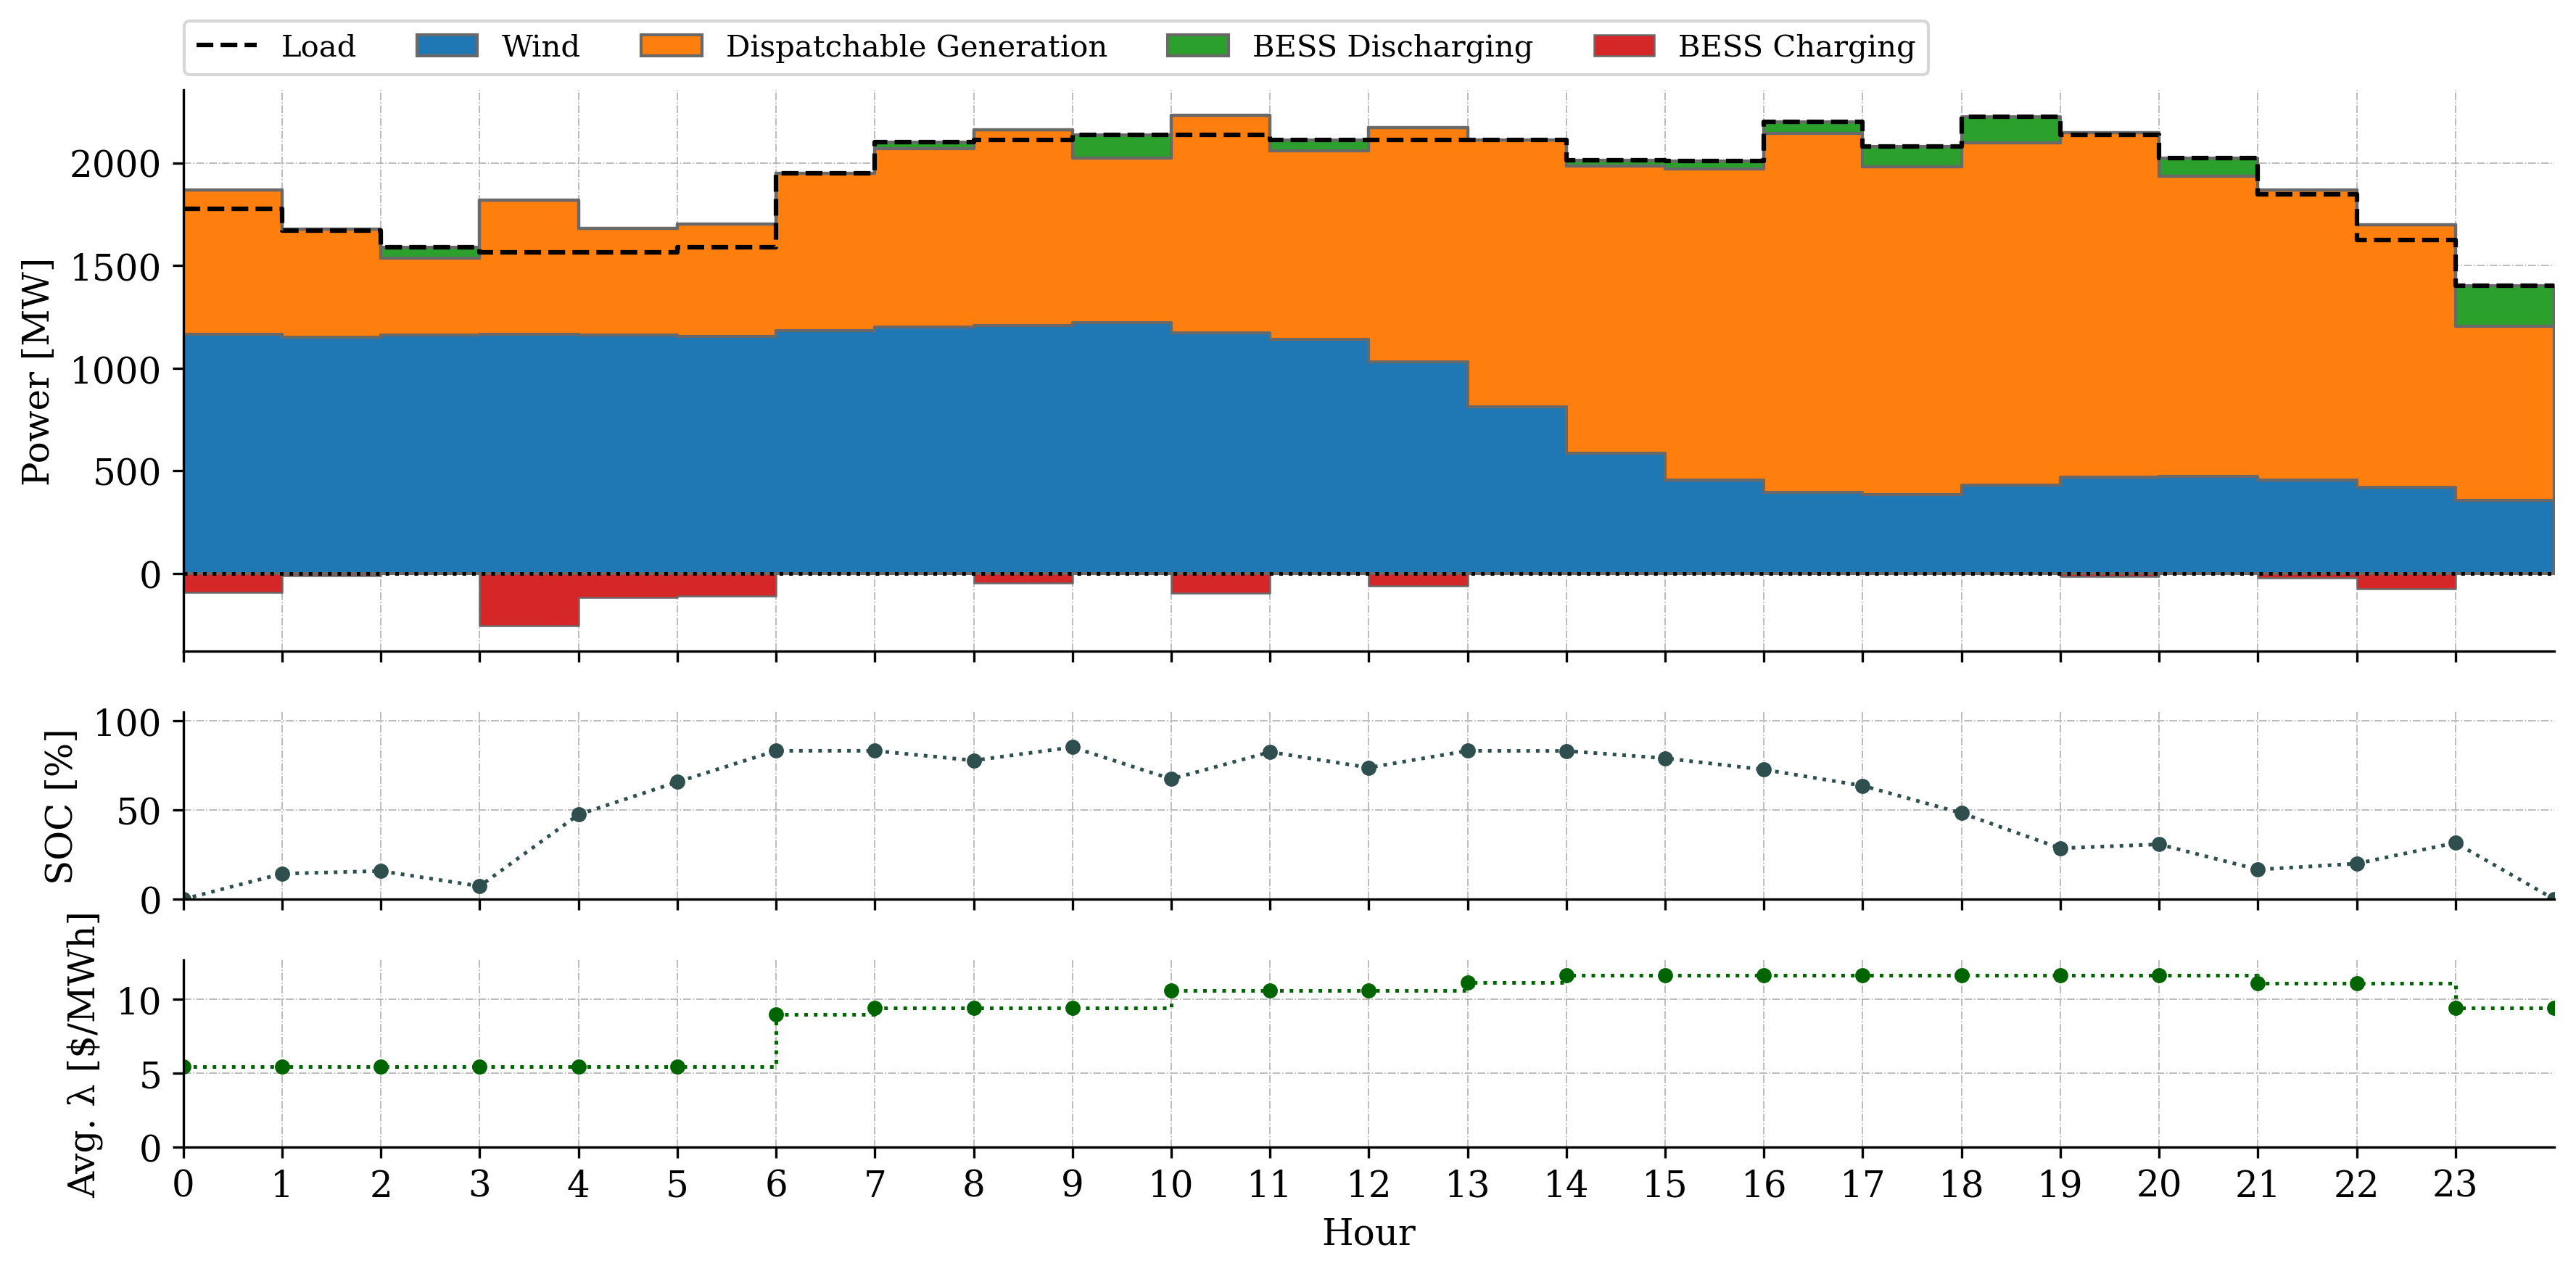

In [50]:
fig, ax = plt.subplots(3,1,sharex=True,figsize=( 12 , 6 ) , dpi=300, gridspec_kw={'height_ratios': [3, 1, 1]}) # Create the figure

df = results.get('overview').copy(deep=True)

#make a final dummy row to include the final hour in the plot
df = pd.concat([df, df.iloc[-1].to_frame().T], ignore_index=True)
df.iloc[-1, 0] = T + 1
df.iloc[-1, -1] = (df.iloc[-2, -1] + eta_bess * (df.iloc[-2, -4] - df.iloc[-2, -3]) / (B * SOC_max)) #update the SOC to the final SOC

#Plotting
ax[0].step(df.index, df['Load [MWh]'], where='post', color='black', label='Load', linestyle='--')

ax[0].stackplot(df.index, df[['Wind [MWh]', 'Dispatchable Production [MWh]', 'BESS Discharging [MWh]']].T, 
                    step='post', edgecolor='dimgrey', labels=['Wind', 'Dispatchable Generation', 'BESS Discharging'], colors=['tab:blue', 'tab:orange', 'tab:green'])

ax[0].stackplot(df.index, -1 * df['BESS Charging [MWh]'].T, step='post', edgecolor='dimgrey', labels=['BESS Charging'], linewidth=0.6, colors=['tab:red'])

ax[0].axhline(0, color='black', linewidth=1.2, linestyle=':')

ax[0].set_ylabel('Power [MW]')
ax[0].legend(loc='upper left', bbox_to_anchor=(-0.006, 1.15),ncol=5, fontsize=10)

ax[1].plot(df.index, df[r'Aggregated BESS SOC [%]'], linestyle=':', color='darkslategrey', linewidth=1.2)
ax[1].plot(df.index, df[r'Aggregated BESS SOC [%]'], linestyle='', marker='o', markersize=4, color='darkslategrey')
ax[1].set_ylabel('SOC [%]')
ax[1].set_ylim([0,105])
ax[1].set_yticks(np.arange(0, 105, 50))

ax[2].step(df.index, df['AVERAGE Lambda [$/MWh]'], linestyle=':', color='darkgreen', linewidth=1.2, where='post')
ax[2].plot(df.index, df['AVERAGE Lambda [$/MWh]'], linestyle='', marker='o', markersize=4, color='darkgreen')
ax[2].set_ylabel('Avg. \u03bb [$/MWh]')
ax[2].set_ylim([0, max(df['AVERAGE Lambda [$/MWh]']) + 1])
ax[2].set_yticks(np.arange(0, max(df['AVERAGE Lambda [$/MWh]']) + 1, 5))

ax[2].set_xticks(np.arange(0,T))
#ax[2].set_xticklabels(np.arange(1,T+2))
ax[2].set_xlabel('Hour')
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)
ax[2].set_axisbelow(True)
ax[0].margins(x=0)

fig.tight_layout() # reduces white space around figures
#plt.savefig('Figures/task_4_multihour_market_clearing.png',bbox_inches='tight')

plt.show()

Hourly visualization of dispatches, load, lambdas and congestion

In [57]:
plot_hour = 0

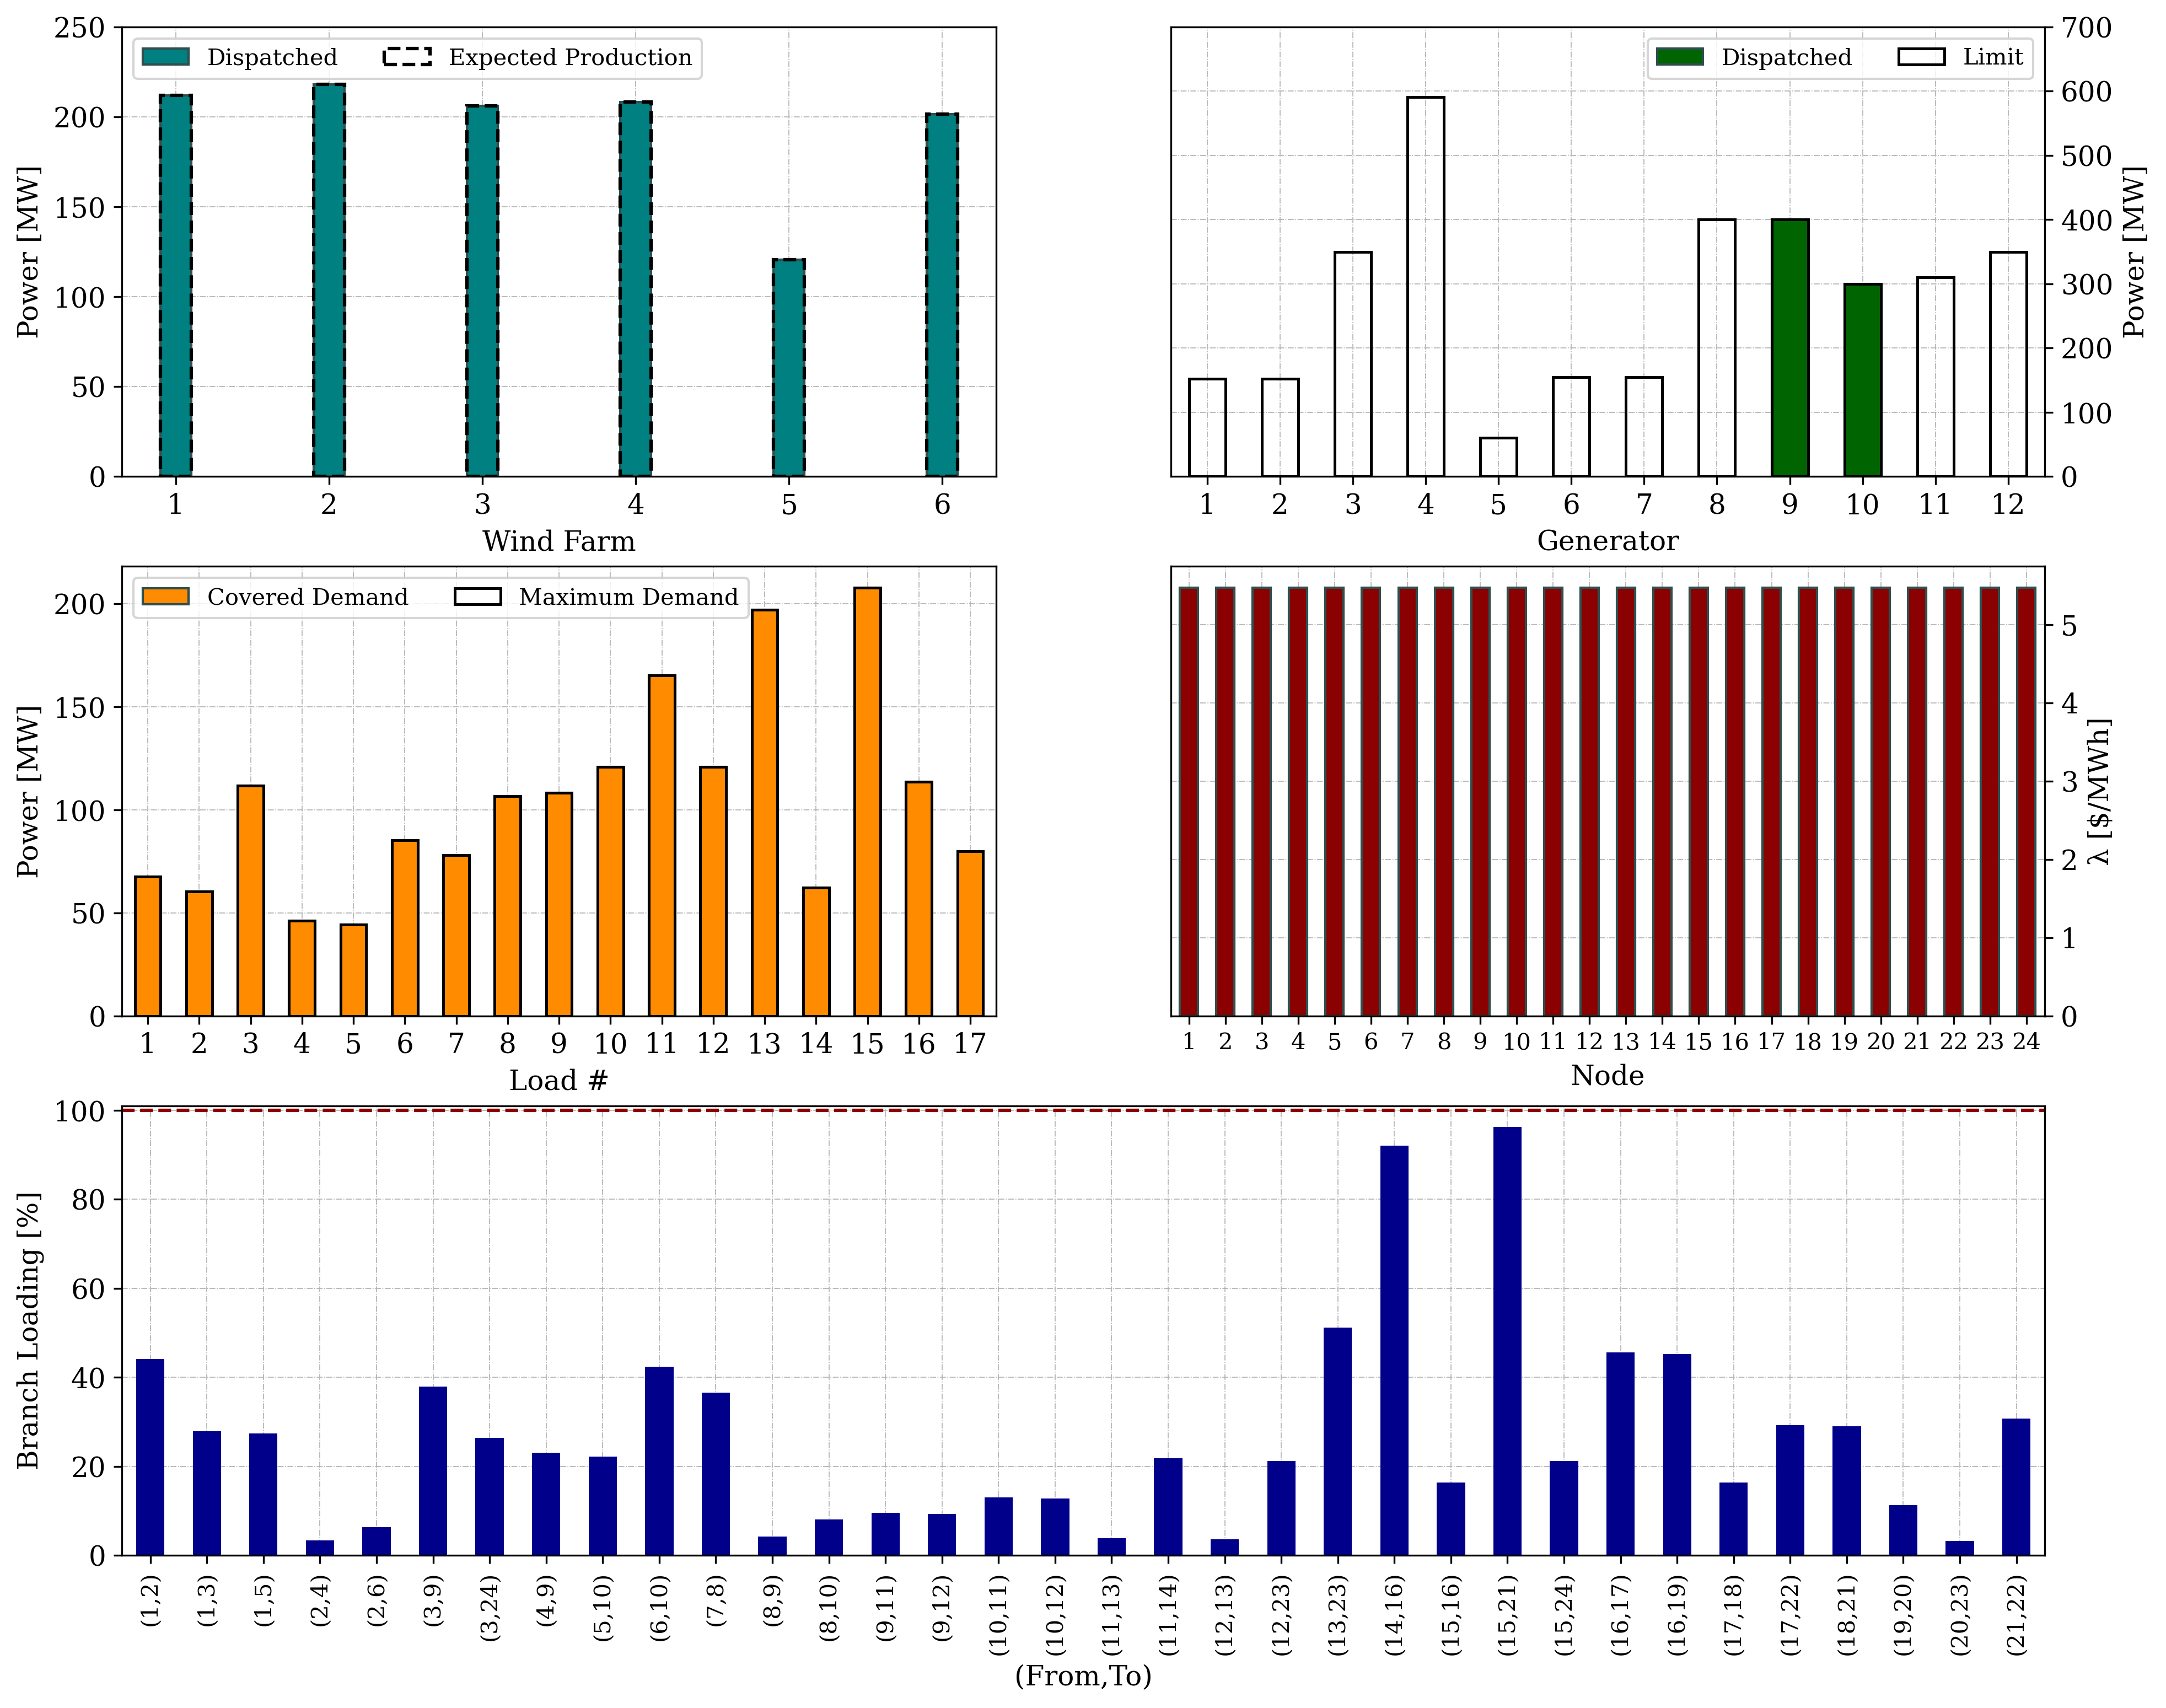

In [64]:
fig = plt.figure(figsize=( 15 , 12 ) , dpi=300) # Create the figure
gs = fig.add_gridspec(3, 2)
ax = []

ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[0, 1]))
ax.append(fig.add_subplot(gs[1, 0]))
ax.append(fig.add_subplot(gs[1, 1]))
ax.append(fig.add_subplot(gs[2, :]))

flow_results = results[plot_hour]['flow'].copy(deep=True)
load_results = results[plot_hour]['demand'].copy(deep=True)
load_results['p_D'] = load_results['p_D'] * S_BASE_MVA
generator_outputs = results[plot_hour]['gen'].copy(deep=True)
generator_outputs['p_G'] = generator_outputs['p_G'] * S_BASE_MVA
lambda_results = results[plot_hour]['lambda'].copy(deep=True)
wind_data_formatted = wind_data.iloc[plot_hour, :].reset_index(drop=True).to_frame().rename(columns={plot_hour: 'Expected Production'})

#========== Plot wind farm results ==========
(generator_outputs.loc[generator_outputs.Type == 'Wind','p_G']).plot(kind='bar', ax=ax[0], color='teal', width=0.2, label='Dispatched', edgecolor='darkslategrey')
wind_data_formatted.plot(kind='bar', ax=ax[0], width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=1.5, label='Expected Production')
ax[0].set_ylabel('Power [MW]')
ax[0].set_xlabel('Wind Farm')
ax[0].set_xticks(ticks = np.arange(0, GW), labels = np.arange(1, GW + 1), fontsize=12, rotation = 0)
ax[0].legend(loc='upper left', ncol=2, fontsize=10)
ax[0].set_ylim([0,250])

#========== Plot conventional generator results ==========
(generator_outputs.loc[generator_outputs.Type == 'Conventional','p_G']).plot(kind='bar', ax=ax[1], color='darkgreen', label='Dispatched', edgecolor='darkslategrey')
gen_data['P max MW'].plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Power [MW]')
ax[1].set_xlabel('Generator')
ax[1].set_xticks(ticks = np.arange(0, GC), labels = np.arange(1, GC + 1), fontsize=12, rotation = 0)
ax[1].legend(loc='upper right', ncol=2, fontsize=10)
ax[1].set_ylim([0,700])

#========== Plot lambda results ==========
lambda_results.plot(kind='bar', ax=ax[3], color='darkred', edgecolor='darkslategrey', legend=False)
ax[3].yaxis.tick_right()
ax[3].yaxis.set_label_position("right")
ax[3].set_ylabel('\u03bb [$/MWh]')
ax[3].set_xlabel('Node')
ax[3].set_xticks(ticks = np.arange(0, N), labels = np.arange(1, N + 1), fontsize=10, rotation = 0)

#========== Plot load dispatch results ==========
load_results['p_D'].plot(kind='bar', ax=ax[2], color='darkorange', label='Covered Demand', edgecolor='darkslategrey')
load_results['Maximum Demand'].plot(kind='bar', ax=ax[2], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Maximum Demand')

ax[2].set_ylabel('Power [MW]')
ax[2].set_xlabel('Load #')
ax[2].set_xticks(ticks = np.arange(0, D), labels = np.arange(1, D + 1), fontsize=12, rotation = 0)
ax[2].legend(loc='upper left', ncol=2, fontsize=10)

#========== Plot branch flow results ==========
flow_labels = []

for row in range(len(flow_results.index)):
    label = '(' + str(flow_results.iloc[row, 0] + 1) + ',' + str(flow_results.iloc[row, 1] + 1) + ')'
    flow_labels.append(label)

flow_results['Loading Percentage'].plot(kind='bar', ax=ax[4], color='darkblue')
ax[4].axhline(100, color='darkred', linestyle='--')
ax[4].set_ylabel('Branch Loading [%]')
ax[4].set_xlabel('(From,To)')
ax[4].set_xticks(ticks = np.arange(0, len(flow_labels), 1), labels = flow_labels, fontsize=10)

for k in range(len(ax)):
    ax[k].spines[['right', 'top']].set_visible(True)
    ax[k].set_axisbelow(True)

#plt.savefig('Figures/task_4_hourly_breakdown_hour_0.png',bbox_inches='tight')
#plt.savefig('Figures/task_4_hourly_breakdown_hour_0_CONGESTED.png',bbox_inches='tight')
plt.show()

# Zonal model

In [9]:
ZONE_NODES = {
    0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    1: [11, 12, 13, 14, 15, 19, 20, 23, 24],
    2: [16, 17, 18, 21, 22]} # NOTE that the nodes are 1-indexed
Z = 3 #number of zones

ATC = {
    (0, 1): 500,
    (0, 2): 500,
    (1, 0): 500,
    (1, 2): 500,
    (2, 0): 500,
    (2, 1): 500
}

SOC_max = 100 # Maximum SOC capacity of each battery (MWh)
SOC_ini = 0 # initial SOC - will also be enforced at the end of the period
P_max_BESS = SOC_max # Maximum charging/discharging power of each battery (MW)
eta_bess = 0.95 # charging and discharging efficiency

In [34]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

#============= Variables =============
#NOTE: Values are in MW
p_G = m.addVars(G, T, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: wind farms can be curtailed AND P_min from the system should be disregarded to avoid having a mixed integer program
p_D = m.addVars(D, T, lb=0, ub=gb.GRB.INFINITY, name="P_D") #Note: demands are elastic
p_B = m.addVars(B, T, lb = -gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="P_B") #battery power (charging is positive, discharging is negative)
bess_SOC = m.addVars(B, T, lb=0, ub=SOC_max, name="BESS_SOC") #battery state of charge
flow = m.addVars(Z, Z, T, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="flow") #cross-zonal flow

#============= Objective function =============
# Set objective function (social welfare) - note that production cost of wind farms is assumed to be zero
obj = (gb.quicksum(bid_prices[d] * p_D[d,t] for d in range(D) for t in range(T)) 
        - gb.quicksum(gen_costs['C ($/MWh)'][k] * p_G[k,t] for k in range(GC) for t in range(T)))
m.setObjective(obj, direction)

#Note: Each constraint will appear for each hour t

#============= Balance equations =============
#Here, we've put the "addConstrs" iterative call inside a for-loop to group the zonal constraints by hours
for t in range(T):
    m.addConstrs(gb.quicksum(p_D[d,t] for d in range(D) if (load_distribution.loc[d, 'Node'] in ZONE_NODES[a])) 
                    - gb.quicksum(p_G[g,t] for g in range(G) if (gen_nodes.loc[g, 'Node'] in ZONE_NODES[a])) 
                    + gb.quicksum(p_B[b,t] for b in range(B) if ((BESS_NODES[b] + 1) in ZONE_NODES[a])) #note that BESS_NODES is 0-indexed, while the nodes are 1-indexed, so we add 1
                    + gb.quicksum(flow[a,j,t] for j in range(Z) if a != j) #flow out of the area is "demand"
                    == 0 for a in range(Z))
    
#============= Cross-zonal flow =============
#no flow from a zone to itself
for t in range(T):
    for a in range(Z):
        flow[a,a,t].lb = 0
        flow[a,a,t].ub = 0

#Flow in one direction is equal to the negative flow in the opposite direction
m.addConstrs(flow[a,b,t] == -1 * flow[b,a,t] for a in range(Z) for b in range(Z) if a != b for t in range(T))

#ATC (Available Transmission Capacity) constraints
for t in range(T):
    m.addConstrs(flow[a,b,t] <= ATC[(a,b)] for a in range(Z) for b in range(Z) if a != b)
    m.addConstrs(flow[a,b,t] >= -1 * ATC[(a,b)] for a in range(Z) for b in range(Z) if a != b)

#============= Generator limits and ramping constraints ============
m.addConstrs(p_G[g,t] <= (gen_data['P max MW'].iloc[g]) for g in range(GC) for t in range(T)) #conventinal generator upper limits

#Maximum wind power is the per-unitized output of the non-curtailed wind farm in the hour t
m.addConstrs(p_G[GC + g, t] <= wind_data.iloc[t, g] for g in range(GW) for t in range(T)) #wind farm generator upper limits

#Ramping constraints
m.addConstrs(p_G[g,t] - p_G[g,t-1] <= (gen_data['RU MW/h'].iloc[g]) for g in range(GC) for t in range(1, T)) #ramping up limitation
m.addConstrs(p_G[g,t-1] - p_G[g,t] <= (gen_data['RD MW/h'].iloc[g]) for g in range(GC) for t in range(1, T)) #ramping down limitation

#============= Demand limits ===============
for t in range(T):
    load = hourly_loads[t].copy()
    m.addConstrs(p_D[d,t] <= load[load != 0][d] for d in range(D)) #demand limits

#============= Battery limits & state of charge ==============
m.addConstrs(p_B[b,t] <= P_max_BESS for b in range(B) for t in range(T))
m.addConstrs(p_B[b,t] >= -P_max_BESS for b in range(B) for t in range(T))

# Initial state of charge for BESSs
m.addConstrs(bess_SOC[b, 0] == SOC_ini for b in range(B)) #note that SOC is handled as SOC at the START of the hour

# Final SOC equal to initial SOC
m.addConstrs(bess_SOC[b, (T - 1)] + eta_bess * p_B[b,(T - 1)] == SOC_ini for b in range(B))

#Inter-temporal SOC balance
m.addConstrs(bess_SOC[b,t] == bess_SOC[b, (t-1)] + eta_bess * p_B[b,(t-1)] for b in range(B) for t in range(1, T)) 

#============= Display and run model =============
#m.update()
#m.display()
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2334 rows, 1344 columns and 4368 nonzeros
Model fingerprint: 0xdeaa5152
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [5e+00, 3e+01]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e+01, 6e+02]
Presolve removed 1969 rows and 330 columns
Presolve time: 0.00s
Presolved: 365 rows, 1175 columns, 1839 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.7342226e+05   7.136078e+03   0.000000e+00      0s
     252    7.8612615e+05   0.000000e+00   0.000000e+00      0s

Use crossover to convert LP symmetric solution to basic solution...
Crossover log...

       0 DPushes remaining with DInf 0.0000000e+00                 0s

      39 PPushes remaining with PInf 0.0000000e+00       

In [35]:
print_variables = False

#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {}
    constraints = m.getConstrs()
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 

    overview = pd.DataFrame(data=np.zeros(T), columns=['Hour'], dtype=int)
    overview['Maximum Demand [MWh]'] = demand.values
    overview['Load [MWh]'] = 0
    overview['Total Production [MWh]'] = 0
    overview['Wind [MWh]'] = 0
    overview['Dispatchable Production [MWh]'] = 0
    overview['BESS Charging [MWh]'] = 0
    overview['BESS Discharging [MWh]'] = 0
    overview['AVERAGE Lambda [$/MWh]'] = 0

    overview[(r'Aggregated BESS SOC [%]')] = 0.0

    #Get results for each hour
    for t in range(T):
        print('==========================================================')
        print('HOUR %d\n' % t)

        hour_results = {}

        generator_outputs = pd.DataFrame(data=np.zeros(G), columns=['p_G'])
        generator_outputs['Node'] = 0 #initialize
        generator_outputs['Dispatched Percentage'] = 0
        generator_outputs['Type'] = 'Conventional'

        load = hourly_loads[t].copy()
        load_results = pd.DataFrame(data=np.zeros(D), columns=['p_D'])
        load_results['Node'] = load_distribution['Node'].values
        load_results['Maximum Demand'] = load[load != 0]

        bess_results = pd.DataFrame(data=np.zeros(B), columns=['Charging [pu]'])
        bess_results[['Discharging [pu]', 'SOC']] = 0.0
        bess_results['Node'] = 0 #initialize

        for i in range(G):
            if print_variables: print(p_G[i,t].VarName + ": %.2f MW" % (p_G[i,t].x))
            generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i,t].x

            if i < GC:
                generator_outputs.loc[generator_outputs.index == i, 'Node'] = gen_data.loc[gen_data.index == i, 'Node'].values #save node
                gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
                generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i,t].x  / gen_limit) * 100
            else:
                generator_outputs.loc[generator_outputs.index == i, 'Node'] = WF_NODES[i - GC] + 1 #save node (from zero-indexed to 1-indexed)
                wind_limit = wind_data.iloc[t, i - GC]
                generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i,t].x / wind_limit) * 100
                generator_outputs.loc[generator_outputs.index == i, 'Type'] = 'Wind'

        for i in range(D):
            if print_variables: print(p_D[i,t].VarName + ": %.2f MW" % (p_D[i,t].x))
            load_results.loc[load_results.index == i, 'p_D'] = p_D[i,t].x

        for b in range(B):
            if print_variables: print(p_B[b,t].VarName + ": %.2f MW" % (p_B[b,t].x))
            if print_variables: print(bess_SOC[b,t].VarName + ": %.2f MWh" % (bess_SOC[b,t].x))
            bess_results.loc[bess_results.index == b, 'Node'] = BESS_NODES[b] + 1 #save node (from zero-indexed to 1-indexed)
            bess_results.loc[bess_results.index == b, 'SOC'] = bess_SOC[b,t].x

            if p_B[b,t].x < 0:
                bess_results.loc[bess_results.index == b, 'Discharging [pu]'] = abs(p_B[b,t].x)
            else:
                bess_results.loc[bess_results.index == b, 'Charging [pu]'] = abs(p_B[b,t].x)


        zone_flows = pd.DataFrame(columns=['From', 'To', 'Flow', 'Loading Percentage'])
        for a in range(Z):
            for b in range(Z): #Avoid duplicates by starting the indexing of b at a
                    if (a != b):
                        zonal_flow = flow[a,b,t].x #flow from a to b

                        loading_percentage = (abs(zonal_flow) / ATC[(a,b)]) * 100

                        new_row = {'From': [a + 1], 'To': [b + 1], 'Flow': [zonal_flow], 'Loading Percentage':loading_percentage}
                        zone_flows = pd.concat([zone_flows, pd.DataFrame(new_row)], axis=0)
        lambda_df = pd.DataFrame(data=np.zeros(Z), columns=['lambda'])
        lambda_hour = np.array(dual_values[(0 + t * Z) : (Z + t * Z)]) #due to per-unitization, they are 100 (S_BASE_MVA) times larger than the actual values

        for a in range(Z):
            lambda_df.loc[lambda_df.index == a, 'lambda'] = lambda_hour[a]

        hour_results['lambda'] = lambda_df.copy(deep=True) #dual values for the balance equations (the first N x T constraints)
        hour_results['gen'] = generator_outputs.copy(deep=True)
        hour_results['demand'] = load_results.copy(deep=True)
        hour_results['bess'] = bess_results.copy(deep=True)
        hour_results['flow'] = zone_flows.reset_index(drop=True).copy(deep=True)
        
        results[t] = hour_results.copy()

        # Results for the overview - used for plotting
        sum_gen = sum(p_G[g,t].x for g in range(GC))
        sum_wind = sum(p_G[g,t].x for g in range(GC, GC + GW))
        sum_production = sum(p_G[g,t].x for g in range(G))
        sum_load = sum(p_D[d,t].x for d in range(D))

        overview.loc[overview.index == t, 'Hour'] = t + 1
        overview.loc[overview.index == t, 'Load [MWh]'] = sum_load
        overview.loc[overview.index == t, 'Total Production [MWh]'] = sum_production
        overview.loc[overview.index == t, 'Wind [MWh]'] = sum_wind
        overview.loc[overview.index == t, 'Dispatchable Production [MWh]'] = sum_gen
        overview.loc[overview.index == t, 'AVERAGE Lambda [$/MWh]'] = np.mean(lambda_hour)

        sum_bess_charge = sum(p_B[b,t].x for b in range(B))
        agg_bess_SOC = sum(bess_SOC[b,t].x for b in range(B)) / (B * SOC_max) #aggregated SOC for all batteries

        overview.loc[overview.index == t, (r'Aggregated BESS SOC [%]')] = agg_bess_SOC * 100

        if sum_bess_charge < 0:
            overview.loc[overview.index == t, 'BESS Discharging [MWh]'] = abs(sum_bess_charge)
        else:
            overview.loc[overview.index == t, 'BESS Charging [MWh]'] = abs(sum_bess_charge)

        #print('-----------------------------------------------')
        print("Total load: %.1f MWh" % sum_load)
        print("Total generation: %.1f MWh" % sum_production)
        print("BESS charge: %.1f MWh" % sum_bess_charge)
        print("Lambdas ($/MWh)", lambda_hour)


    print('==========================================================')
    print("Optimal objective value: %.2f $" % m.objVal)
    overview = overview.set_index('Hour')
    results['overview'] = overview.copy(deep=True)

else:
    print("Optimization was not successful.")     

overview

HOUR 0

Total load: 1775.8 MWh
Total generation: 1866.4 MWh
BESS charge: 90.6 MWh
Lambdas ($/MWh) [5.47 5.47 5.47]
HOUR 1

Total load: 1669.8 MWh
Total generation: 1823.9 MWh
BESS charge: 154.1 MWh
Lambdas ($/MWh) [5.47 5.47 5.47]
HOUR 2

Total load: 1590.3 MWh
Total generation: 1556.1 MWh
BESS charge: -34.2 MWh
Lambdas ($/MWh) [5.47 5.47 5.47]
HOUR 3

Total load: 1563.8 MWh
Total generation: 1536.2 MWh
BESS charge: -27.6 MWh
Lambdas ($/MWh) [5.47 5.47 5.47]
HOUR 4

Total load: 1563.8 MWh
Total generation: 1812.5 MWh
BESS charge: 248.7 MWh
Lambdas ($/MWh) [5.47 5.47 5.47]
HOUR 5

Total load: 1590.3 MWh
Total generation: 1790.3 MWh
BESS charge: 200.0 MWh
Lambdas ($/MWh) [5.47 5.47 5.47]
HOUR 6

Total load: 1961.4 MWh
Total generation: 1882.2 MWh
BESS charge: -79.2 MWh
Lambdas ($/MWh) [6.02 6.02 6.02]
HOUR 7

Total load: 2279.4 MWh
Total generation: 2071.3 MWh
BESS charge: -208.1 MWh
Lambdas ($/MWh) [10.   10.    6.02]
HOUR 8

Total load: 2272.0 MWh
Total generation: 2305.1 MWh
BESS char

,Maximum Demand [MWh],Load [MWh],Total Production [MWh],Wind [MWh],Dispatchable Production [MWh],BESS Charging [MWh],BESS Discharging [MWh],AVERAGE Lambda [$/MWh],Aggregated BESS SOC [%]
Hour,,,,,,,,,
1,1775.835,1775.835000,1866.442579,1166.442579,700.000000,90.607579,0.000000,5.470000,0.000000
2,1669.815,1669.815000,1823.897434,1150.804786,673.092648,154.082434,0.000000,5.470000,14.346200
3,1590.300,1590.300000,1556.136303,1163.043655,393.092648,0.000000,34.163697,5.470000,38.742585
4,1563.795,1563.795000,1536.189597,1163.823527,372.366071,0.000000,27.605403,5.470000,33.333333
5,1563.795,1563.795000,1812.453034,1160.086964,652.366071,248.658034,0.000000,5.470000,28.962478
6,1590.300,1590.300000,1790.300000,1156.524985,633.775015,200.000000,0.000000,5.470000,68.333333
7,1961.370,1961.370000,1882.213950,1182.213950,700.000000,0.000000,79.156050,6.020000,100.000000
8,2279.430,2279.430000,2071.308735,1202.197011,869.111724,0.000000,208.121265,8.673333,87.466959
9,2517.975,2272.029360,2305.120518,1207.324249,1097.796269,33.091158,0.000000,8.673333,54.514425


### Zonal overview

In [36]:
constraints = m.getConstrs()
dual_values = [constraints[k].Pi for k in range(len(constraints))] 

zonal_overview = pd.DataFrame(data=np.zeros(T), columns=['Hour'], dtype=int)
zonal_overview['Maximum Demand excl. BESS [MWh]'] = demand.values
zonal_overview['Total Load [MWh]'] = 0
zonal_overview[['Area 1 Load [MWh]', 'Area 2 Load [MWh]', 'Area 3 Load [MWh]']] = 0
zonal_overview['Total Production [MWh]'] = 0
zonal_overview[['Area 1 Production [MWh]', 'Area 2 Production [MWh]', 'Area 3 Production [MWh]']] = 0
zonal_overview[['Area 1 Lambda [$/MWh]', 'Area 2 Lambda [$/MWh]', 'Area 3 Lambda [$/MWh]']] = 0

#Get results for each hour
for t in range(T):
    zonal_overview.loc[zonal_overview.index == t, 'Hour'] = t + 1

    for a in range(Z):
        zonal_overview.loc[zonal_overview.index == t, 'Area %d Lambda [$/MWh]' % (a + 1)] = dual_values[(a + t * Z)]

    for d in range(D):
        zonal_overview.loc[zonal_overview.index == t, 'Total Load [MWh]'] += p_D[d,t].x
        
        if load_distribution.loc[d, 'Node'] in ZONE_NODES[0]:
            zonal_overview.loc[zonal_overview.index == t, 'Area 1 Load [MWh]'] += p_D[d,t].x
        elif load_distribution.loc[d, 'Node'] in ZONE_NODES[1]:
            zonal_overview.loc[zonal_overview.index == t, 'Area 2 Load [MWh]'] += p_D[d,t].x
        else:
            zonal_overview.loc[zonal_overview.index == t, 'Area 3 Load [MWh]'] += p_D[d,t].x

    for g in range(G):
        zonal_overview.loc[zonal_overview.index == t, 'Total Production [MWh]'] += p_G[g,t].x

        if gen_nodes.loc[g, 'Node'] in ZONE_NODES[0]:
            zonal_overview.loc[zonal_overview.index == t, 'Area 1 Production [MWh]'] += p_G[g,t].x
        elif gen_nodes.loc[g, 'Node'] in ZONE_NODES[1]:
            zonal_overview.loc[zonal_overview.index == t, 'Area 2 Production [MWh]'] += p_G[g,t].x
        else:
            zonal_overview.loc[zonal_overview.index == t, 'Area 3 Production [MWh]'] += p_G[g,t].x

    for b in range(B):
        if p_B[b,t].x < 0:
            zonal_overview.loc[zonal_overview.index == t, 'Total Production [MWh]'] += abs(p_B[b,t].x)

            if (BESS_NODES[b] + 1) in ZONE_NODES[0]:
                zonal_overview.loc[zonal_overview.index == t, 'Area 1 Production [MWh]'] += abs(p_B[b,t].x)
            elif (BESS_NODES[b] + 1) in ZONE_NODES[1]:
                zonal_overview.loc[zonal_overview.index == t, 'Area 2 Production [MWh]'] += abs(p_B[b,t].x)
            else:
                zonal_overview.loc[zonal_overview.index == t, 'Area 3 Production [MWh]'] += abs(p_B[b,t].x)

        else:
            zonal_overview.loc[zonal_overview.index == t, 'Total Load [MWh]'] += abs(p_B[b,t].x)

            if (BESS_NODES[b] + 1) in ZONE_NODES[0]:
                zonal_overview.loc[zonal_overview.index == t, 'Area 1 Load [MWh]'] += abs(p_B[b,t].x)
            elif (BESS_NODES[b] + 1) in ZONE_NODES[1]:
                zonal_overview.loc[zonal_overview.index == t, 'Area 2 Load [MWh]'] += abs(p_B[b,t].x)
            else:
                zonal_overview.loc[zonal_overview.index == t, 'Area 3 Load [MWh]'] += abs(p_B[b,t].x)

            

zonal_overview = zonal_overview.set_index('Hour')
print('NOTE: In this dataframe, production values include BESS discharging and load values include BESS charging.')
zonal_overview

NOTE: In this dataframe, production values include BESS discharging and load values include BESS charging.


,Maximum Demand excl. BESS [MWh],Total Load [MWh],Area 1 Load [MWh],Area 2 Load [MWh],Area 3 Load [MWh],Total Production [MWh],Area 1 Production [MWh],Area 2 Production [MWh],Area 3 Production [MWh],Area 1 Lambda [$/MWh],Area 2 Lambda [$/MWh],Area 3 Lambda [$/MWh]
Hour,,,,,,,,,,,,
1,1775.835,1866.442579,919.922524,676.593135,269.926920,1866.442579,636.039010,201.658639,1028.744929,5.47,5.47,5.47
2,1669.815,1880.341316,879.803605,736.199515,264.338196,1880.341316,686.683349,195.609866,998.048101,5.47,5.47,5.47
3,1590.300,1790.300000,742.670100,605.904300,441.725600,1790.300000,776.639787,291.041179,722.619034,5.47,5.47,5.47
4,1563.795,1736.189597,802.686862,695.805895,237.696840,1736.189597,643.139509,193.846189,899.203899,5.47,5.47,5.47
5,1563.795,1812.453034,973.687141,601.069053,237.696840,1812.453034,642.087501,190.522568,979.842966,5.47,5.47,5.47
6,1590.300,1790.300000,742.670100,605.904300,441.725600,1790.300000,639.107744,190.733644,960.458612,5.47,5.47,5.47
7,1961.370,1961.370000,915.959790,747.281970,298.128240,1961.370000,646.068348,197.445395,1117.856258,6.02,6.02,6.02
8,2279.430,2279.430000,1064.493810,868.462830,346.473360,2279.430000,654.464092,278.492548,1346.473360,10.00,10.00,6.02
9,2517.975,2333.632676,1004.672025,884.625135,444.335516,2333.632676,656.717452,232.579708,1444.335516,10.00,10.00,6.02


Check with flows

In [37]:
results[0]['flow']

,From,To,Flow,Loading Percentage
0,1,2,216.116486,43.223297
1,1,3,-500.000000,100.000000
2,2,1,-216.116486,43.223297
3,2,3,-258.818009,51.763602
4,3,1,500.000000,100.000000
5,3,2,258.818009,51.763602
